In [1]:
import xarray as xr
import numpy as np
import skimage
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
ds_currents = xr.open_dataset('E:\Proyecto de Grado\Data\corrientes_u_v_5m_enero1993_diciembre2020.nc')
ds_currents

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, time: 336, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Dividimos en meses

In [3]:
ds_monthly = ds_currents.groupby('time.month').mean()
ds_monthly

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 12, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    vo         (month, depth, latitude, longitude) float32 0.1063 ... 0.02531
    uo         (month, depth, latitude, longitude) float32 0.1706 ... -0.002202
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

<h3>Epoca seca de Diciembre a Marzo</h3>

In [5]:
ds_dec_mar = ds_monthly.sel({'month': [12, 1, 2, 3]})
ds_dec_mar

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 4, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 12 1 2 3
Data variables:
    vo         (month, depth, latitude, longitude) float32 0.05988 ... -0.02258
    uo         (month, depth, latitude, longitude) float32 0.23 ... 0.01506
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [6]:
lat = ds_dec_mar['latitude'].to_numpy()
lon = ds_dec_mar['longitude'].to_numpy()
V = ds_dec_mar["vo"].mean(dim=["month","depth"]).to_numpy()
U = ds_dec_mar["uo"].mean(dim=["month","depth"]).to_numpy()

X, Y = np.meshgrid(lon, lat)

In [7]:
x = skimage.measure.block_reduce(X, (7, 7), np.nanmean)
y = skimage.measure.block_reduce(Y, (7, 7), np.nanmean)
u = skimage.measure.block_reduce(U, (7, 7), np.nanmean)
v = skimage.measure.block_reduce(V, (7, 7), np.nanmean)

c:\ProgramData\anaconda3\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


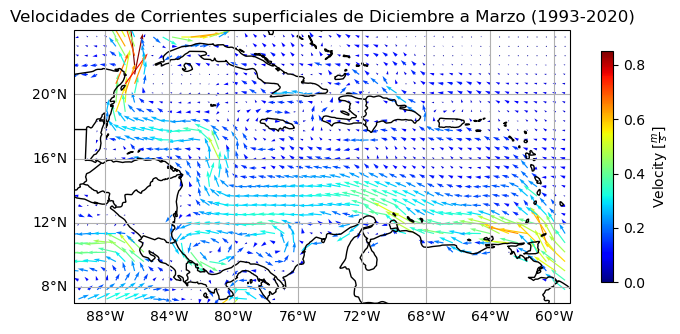

In [9]:
# Crea una figura y ejes con la proyección de latitud y longitud
fig, ax = plt.subplots(1, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
loc = ticker.MultipleLocator(4)

# Agrega el mapa base (costas, límites de países, etc.)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)

# Crea el gráfico de vectores
Q = ax.quiver(x, y, u, v, np.sqrt(u**2 + v**2), scale=10, cmap= 'jet')

# Agrega una barra de color asociada a la magnitud de los vectores
plt.colorbar(Q, label=r"Velocity [$\frac{m}{s}$]", shrink = 0.5)

# Establece los límites del mapa y etiquetas de los ejes
ax.set(ylim=(lat.min(), lat.max()), xlim=(lon.min(), lon.max()))

# Agrega un marco naval con las coordenadas en rojo y con líneas discontinuas
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, xlocs=loc, ylocs=loc)

# Muestra el mapa
plt.title("Velocidades de Corrientes superficiales de Diciembre a Marzo (1993-2020)")
plt.show()

<h3>Epoca lluviosa Abril a Mayo</h3>

In [12]:
ds_apr_may = ds_monthly.sel(month= slice(4,5))
ds_apr_may

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 2, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 4 5
Data variables:
    vo         (month, depth, latitude, longitude) float32 0.04092 ... 0.02579
    uo         (month, depth, latitude, longitude) float32 0.3758 ... -0.01923
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [13]:
lat = ds_apr_may['latitude'].to_numpy()
lon = ds_apr_may['longitude'].to_numpy()
V = ds_apr_may["vo"].mean(dim=["month","depth"]).to_numpy()
U = ds_apr_may["uo"].mean(dim=["month","depth"]).to_numpy()

X, Y = np.meshgrid(lon, lat)

In [14]:
x = skimage.measure.block_reduce(X, (7, 7), np.nanmean)
y = skimage.measure.block_reduce(Y, (7, 7), np.nanmean)
u = skimage.measure.block_reduce(U, (7, 7), np.nanmean)
v = skimage.measure.block_reduce(V, (7, 7), np.nanmean)

c:\ProgramData\anaconda3\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


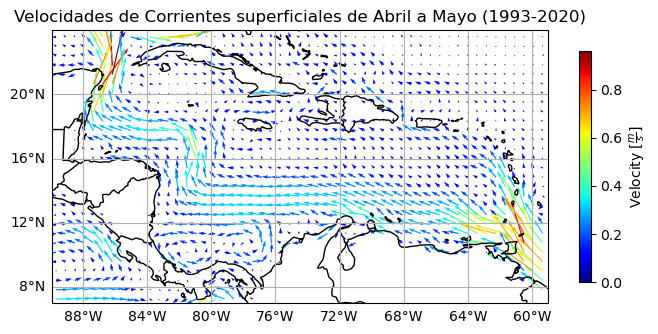

In [15]:
# Crea una figura y ejes con la proyección de latitud y longitud
fig, ax = plt.subplots(1, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
loc = ticker.MultipleLocator(4)

# Agrega el mapa base (costas, límites de países, etc.)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)

# Crea el gráfico de vectores
Q = ax.quiver(x, y, u, v, np.sqrt(u**2 + v**2), scale=10, cmap= 'jet')

# Agrega una barra de color asociada a la magnitud de los vectores
plt.colorbar(Q, label=r"Velocity [$\frac{m}{s}$]", shrink = 0.5)

# Establece los límites del mapa y etiquetas de los ejes
ax.set(ylim=(lat.min(), lat.max()), xlim=(lon.min(), lon.max()))

# Agrega un marco naval con las coordenadas en rojo y con líneas discontinuas
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, xlocs=loc, ylocs=loc)

# Muestra el mapa
plt.title("Velocidades de Corrientes superficiales de Abril a Mayo (1993-2020)")
plt.show()

<h3>Intermedio de Junio a Septiembre</h3>

In [16]:
ds_jun_sep = ds_monthly.sel(month= slice(6,9))
ds_jun_sep

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 4, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 6 7 8 9
Data variables:
    vo         (month, depth, latitude, longitude) float32 -0.03272 ... 0.04369
    uo         (month, depth, latitude, longitude) float32 0.2893 ... -0.006888
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [17]:
lat = ds_jun_sep['latitude'].to_numpy()
lon = ds_jun_sep['longitude'].to_numpy()
V = ds_jun_sep["vo"].mean(dim=["month","depth"]).to_numpy()
U = ds_jun_sep["uo"].mean(dim=["month","depth"]).to_numpy()

X, Y = np.meshgrid(lon, lat)

In [18]:
x = skimage.measure.block_reduce(X, (7, 7), np.nanmean)
y = skimage.measure.block_reduce(Y, (7, 7), np.nanmean)
u = skimage.measure.block_reduce(U, (7, 7), np.nanmean)
v = skimage.measure.block_reduce(V, (7, 7), np.nanmean)

c:\ProgramData\anaconda3\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


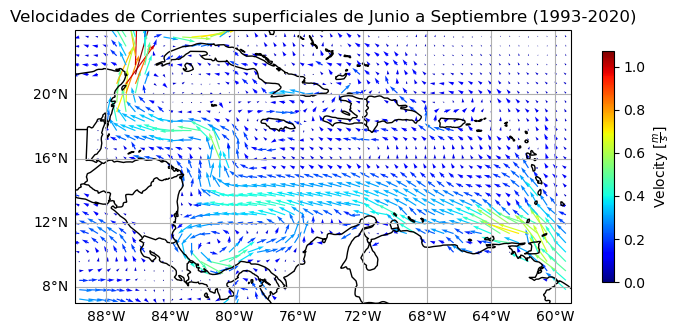

In [19]:
# Crea una figura y ejes con la proyección de latitud y longitud
fig, ax = plt.subplots(1, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
loc = ticker.MultipleLocator(4)

# Agrega el mapa base (costas, límites de países, etc.)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)

# Crea el gráfico de vectores
Q = ax.quiver(x, y, u, v, np.sqrt(u**2 + v**2), scale=10, cmap= 'jet')

# Agrega una barra de color asociada a la magnitud de los vectores
plt.colorbar(Q, label=r"Velocity [$\frac{m}{s}$]", shrink = 0.5)

# Establece los límites del mapa y etiquetas de los ejes
ax.set(ylim=(lat.min(), lat.max()), xlim=(lon.min(), lon.max()))

# Agrega un marco naval con las coordenadas en rojo y con líneas discontinuas
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, xlocs=loc, ylocs=loc)

# Muestra el mapa
plt.title("Velocidades de Corrientes superficiales de Junio a Septiembre (1993-2020)")
plt.show()

<h3>Época humeda de Octubre a Noviembre</h3>

In [20]:
ds_oct_nov = ds_monthly.sel(month= slice(10,11))
ds_oct_nov

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 2, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 10 11
Data variables:
    vo         (month, depth, latitude, longitude) float32 -0.09799 ... 0.016
    uo         (month, depth, latitude, longitude) float32 0.2927 ... 0.01338
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [21]:
lat = ds_oct_nov['latitude'].to_numpy()
lon = ds_oct_nov['longitude'].to_numpy()
V = ds_oct_nov["vo"].mean(dim=["month","depth"]).to_numpy()
U = ds_oct_nov["uo"].mean(dim=["month","depth"]).to_numpy()

X, Y = np.meshgrid(lon, lat)

In [22]:
x = skimage.measure.block_reduce(X, (7, 7), np.nanmean)
y = skimage.measure.block_reduce(Y, (7, 7), np.nanmean)
u = skimage.measure.block_reduce(U, (7, 7), np.nanmean)
v = skimage.measure.block_reduce(V, (7, 7), np.nanmean)

c:\ProgramData\anaconda3\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


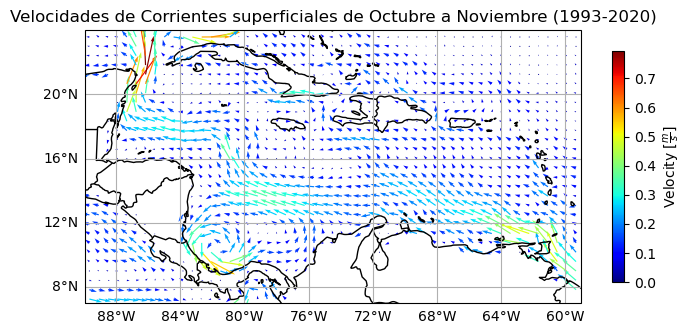

In [23]:
# Crea una figura y ejes con la proyección de latitud y longitud
fig, ax = plt.subplots(1, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
loc = ticker.MultipleLocator(4)

# Agrega el mapa base (costas, límites de países, etc.)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)

# Crea el gráfico de vectores
Q = ax.quiver(x, y, u, v, np.sqrt(u**2 + v**2), scale=10, cmap= 'jet')

# Agrega una barra de color asociada a la magnitud de los vectores
plt.colorbar(Q, label=r"Velocity [$\frac{m}{s}$]", shrink = 0.5)

# Establece los límites del mapa y etiquetas de los ejes
ax.set(ylim=(lat.min(), lat.max()), xlim=(lon.min(), lon.max()))

# Agrega un marco naval con las coordenadas en rojo y con líneas discontinuas
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, xlocs=loc, ylocs=loc)

# Muestra el mapa
plt.title("Velocidades de Corrientes superficiales de Octubre a Noviembre (1993-2020)")
plt.show()